In [1]:
import numpy as np
import nibabel as nib
import glob
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [22]:
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())

1854.603271484375



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


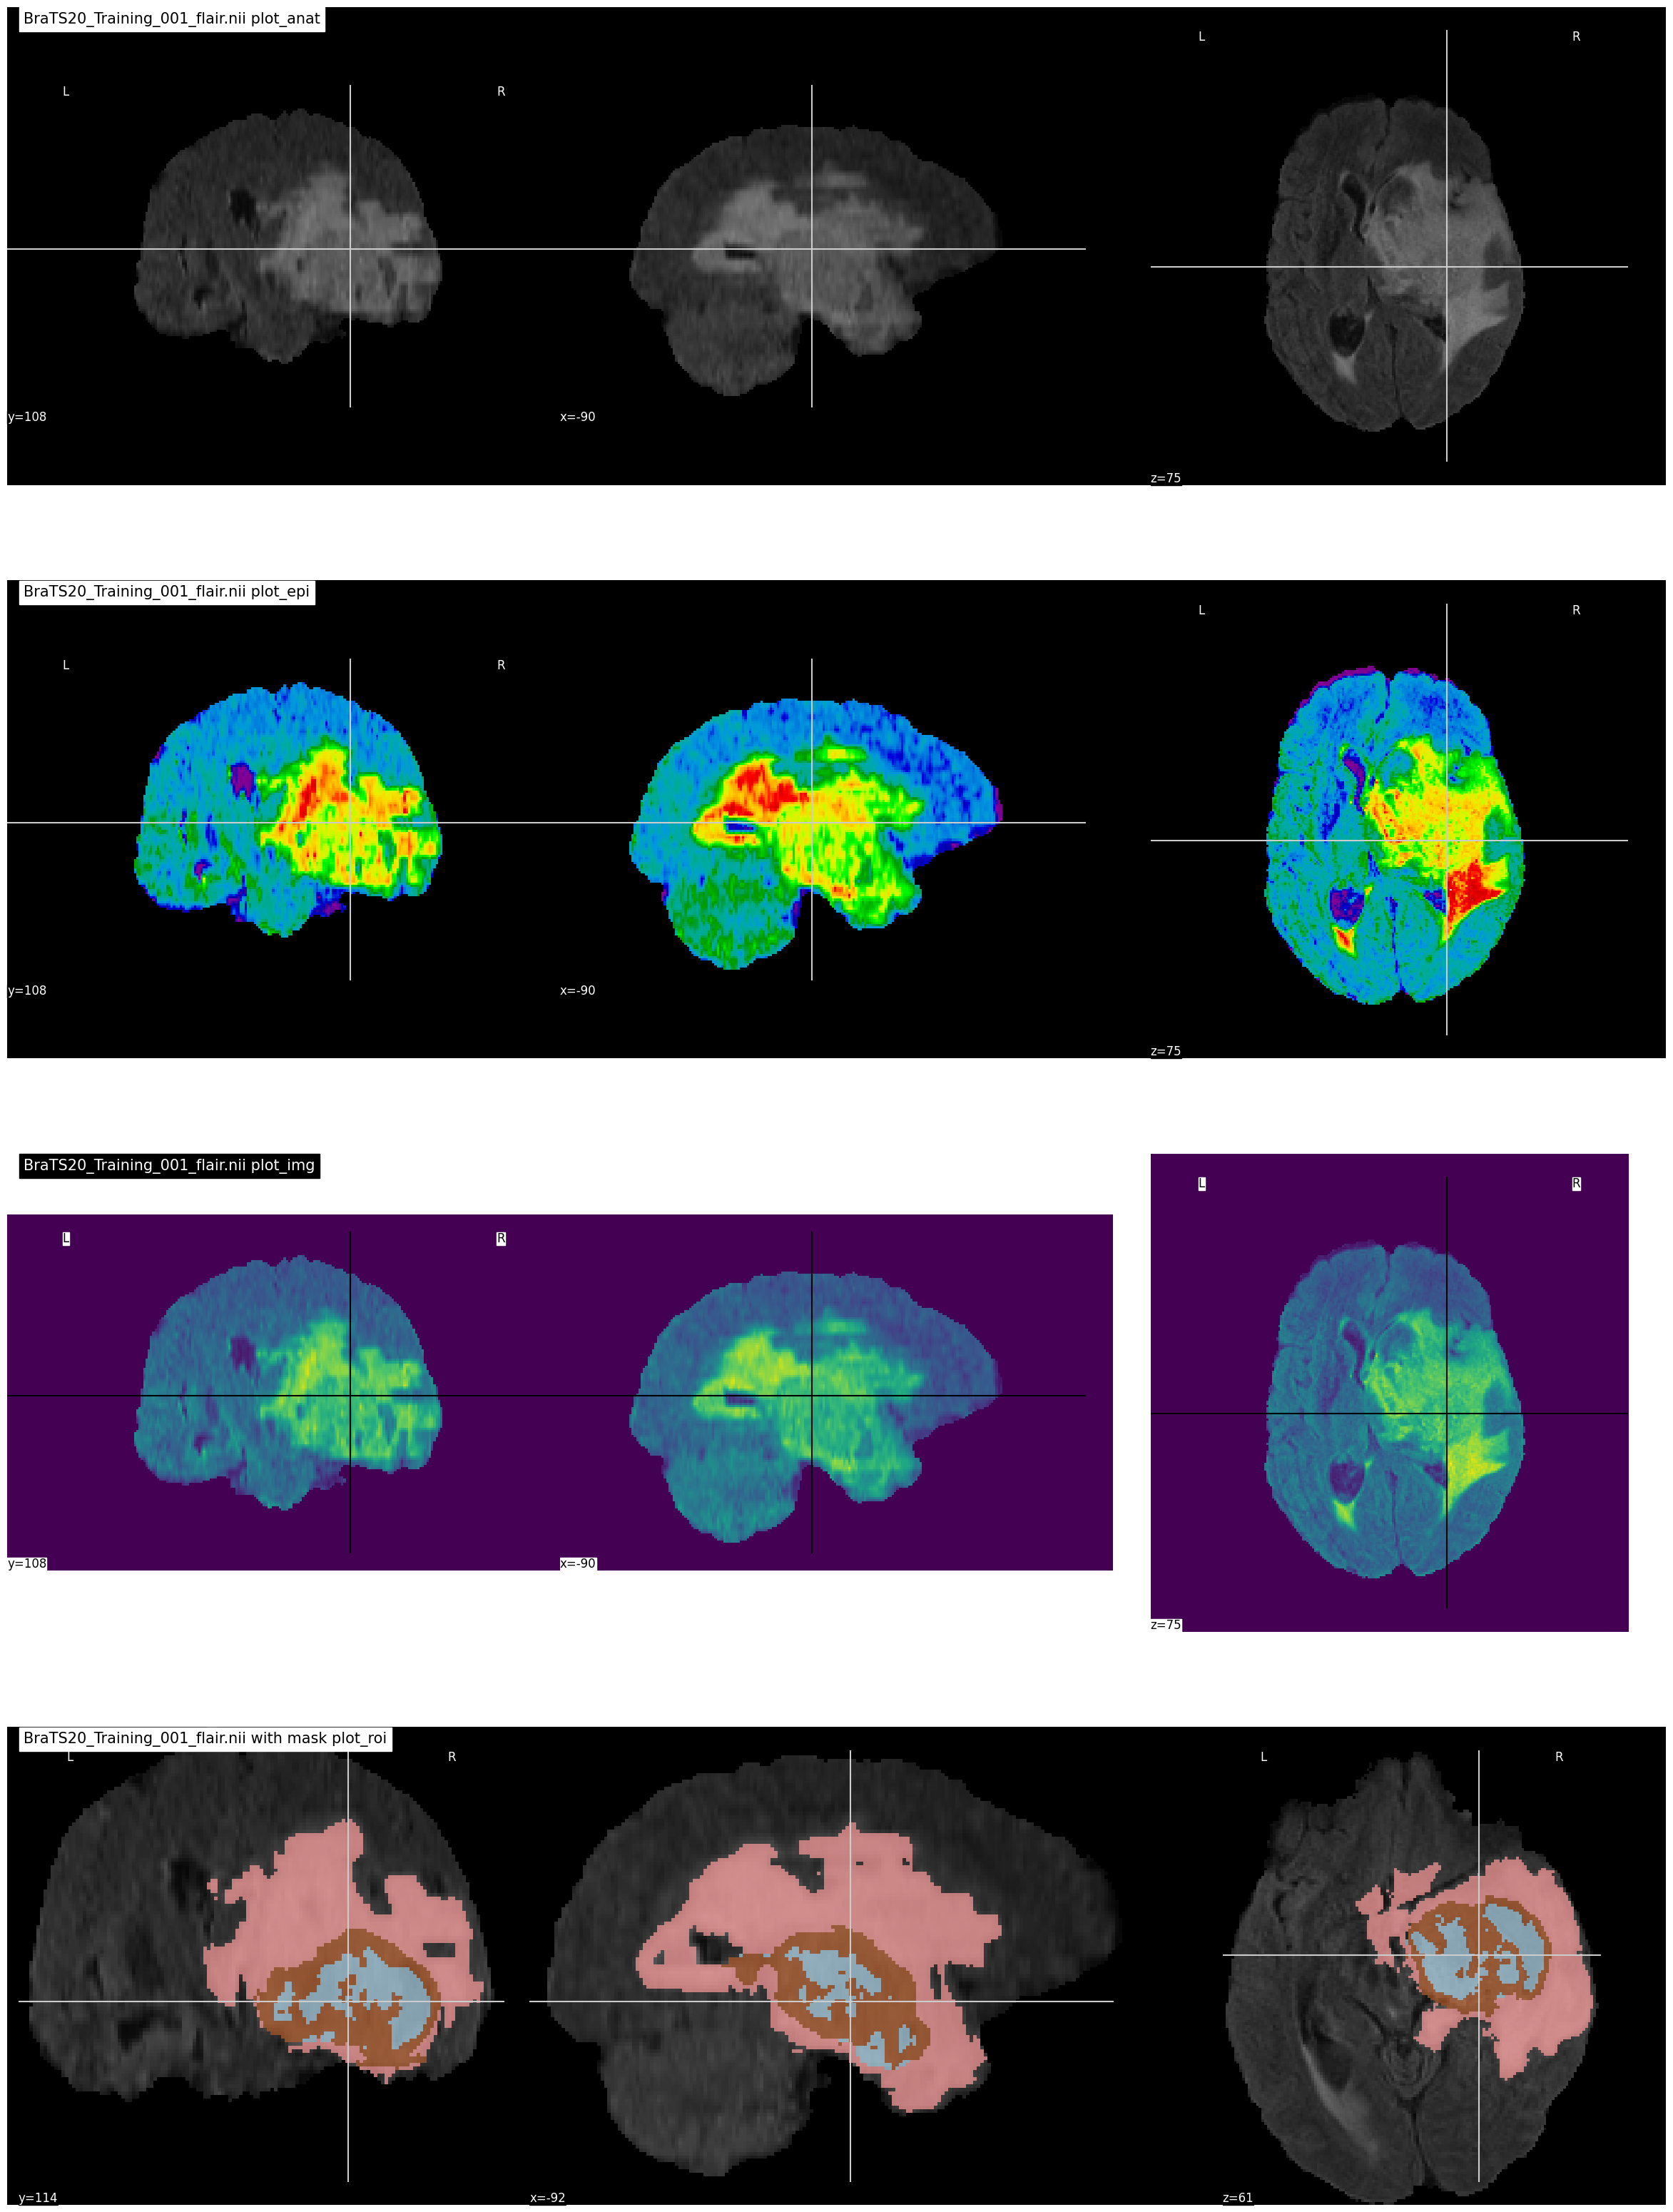

In [50]:
!pip install nilearn
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [23]:
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


In [24]:
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

In [25]:
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8) #prev were float dont need that
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 


[0 1 2 4]
[0 1 2 3]


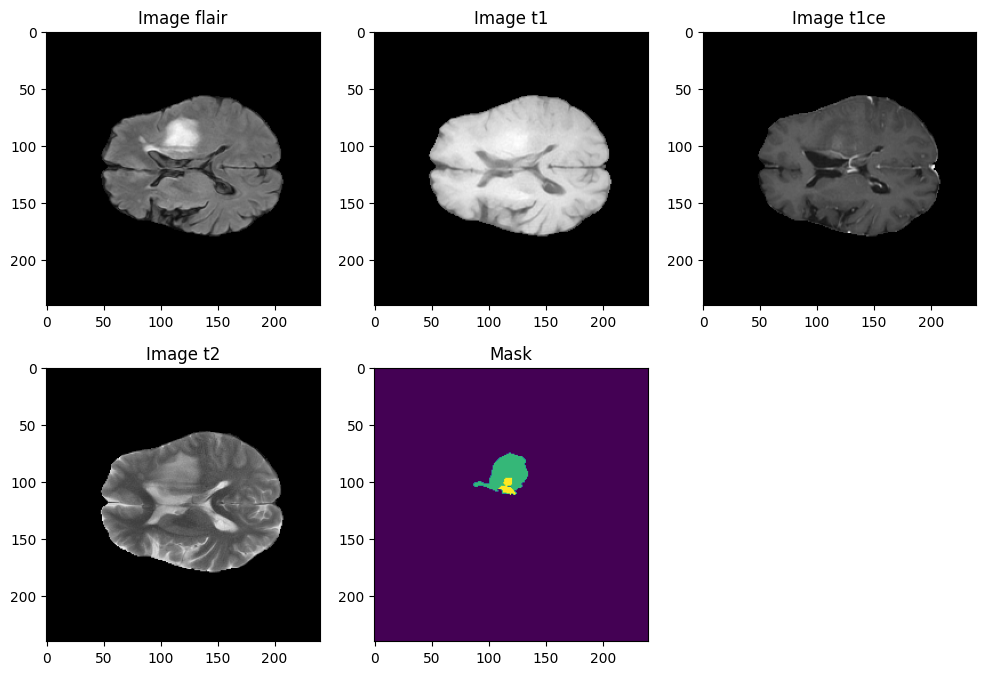

In [27]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [28]:
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

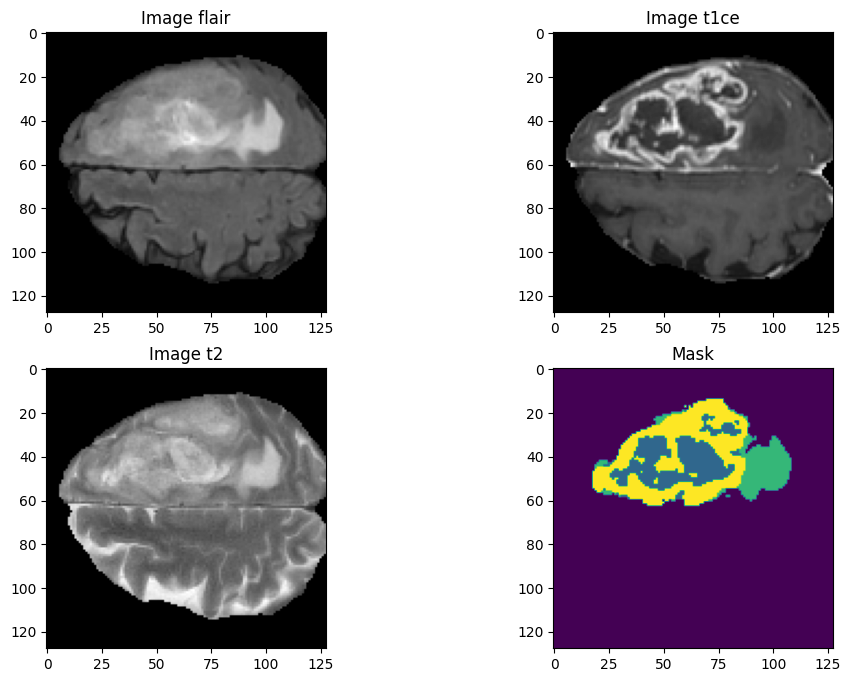

In [36]:


n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [37]:
np.save('BraTS2020_TrainingData/combined255.npy', combined_x)
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load('BraTS2020_TrainingData/combined255.npy')

test_mask = to_categorical(test_mask, num_classes=4)
##############################################################

In [38]:
t2_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
t2_list

['BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_t2.nii',
 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_002\\BraTS20_Training_002_t2.nii',
 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_003\\BraTS20_Training_003_t2.nii',
 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_004\\BraTS20_Training_004_t2.nii',
 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_005\\BraTS20_Training_005_t2.nii',
 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_006\\BraTS20_Training_006_t2.nii',
 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_007\\BraTS20_Training_007_t2.nii',
 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_008\\BraTS20_Training_008_t2.nii',
 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_009\\BraTS20_Training_009_t2.nii',
 'BraTS2020_TrainingData/MIC

In [39]:
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('BraTS2020_TrainingData/input_data/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('BraTS2020_TrainingData/input_data/masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")   

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now p

In [54]:
!pip install split-folders
import splitfolders 

input_folder = 'BraTS2020_TrainingData/input_data/'
output_folder = 'BraTS2020_TrainingData/input_data_128/'
# Split with a ratio.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Copying files: 688 files [00:55, 12.32 files/s]


In [62]:
def threeD_Unet(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, IMG_CHANNELS, num_classes):

    inputs = tf.keras.layers.Input(( IMG_HEIGHT,IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)
    s=inputs

    
    C1 = tf.keras.layers.Conv3D(16, (3,3,3), activation = 'relu', kernel_initializer ='he_normal', padding ='same')(s)
    C1 = tf.keras.layers.Dropout(0.1)(C1)
    C1 = tf.keras.layers.Conv3D(16, (3,3, 3), activation = 'relu', kernel_initializer ='he_normal', padding ='same')(C1)
    p1 = tf.keras.layers.MaxPooling3D((2, 2, 2))(C1)
    
    C2 = tf.keras.layers.Conv3D(32, (3,3,3), activation = 'relu', kernel_initializer ='he_normal', padding ='same')(p1)
    C2 = tf.keras.layers.Dropout(0.1)(C2)
    C2 = tf.keras.layers.Conv3D(32, (3,3,3), activation = 'relu', kernel_initializer ='he_normal', padding ='same')(C2)
    p2 = tf.keras.layers.MaxPooling3D((2, 2, 2))(C2)
    
    C3 = tf.keras.layers.Conv3D(64, (3,3,3), activation = 'relu', kernel_initializer ='he_normal', padding ='same')(p2)
    C3 = tf.keras.layers.Dropout(0.1)(C3)
    C3 = tf.keras.layers.Conv3D(64, (3,3,3), activation = 'relu', kernel_initializer ='he_normal', padding ='same')(C3)
    p3 = tf.keras.layers.MaxPooling3D((2, 2, 2))(C3)
    
    C4 = tf.keras.layers.Conv3D(128, (3,3,3), activation = 'relu', kernel_initializer ='he_normal', padding ='same')(p3)
    C4 = tf.keras.layers.Dropout(0.1)(C4)
    C4 = tf.keras.layers.Conv3D(128, (3,3,3), activation = 'relu', kernel_initializer ='he_normal', padding ='same')(C4)
    p4 = tf.keras.layers.MaxPooling3D((2, 2, 2))(C4)
    
    C5 = tf.keras.layers.Conv3D(256, (3,3,3), activation = 'relu', kernel_initializer ='he_normal', padding ='same')(p4)
    C5 = tf.keras.layers.Dropout(0.1)(C5)
    C5 = tf.keras.layers.Conv3D(256, (3,3,3), activation = 'relu', kernel_initializer ='he_normal', padding ='same')(C5)
    
    
    U6 = tf.keras.layers.Conv3DTranspose(128, (2, 2, 2), strides = (2,2,2) , padding = 'same')(C5)
    U6 = tf.keras.layers.concatenate([U6, C4])
    C6 = tf.keras.layers.Conv3D(128, (3,3,3), activation ='relu', kernel_initializer='he_normal', padding='same')(U6)
    C6 = tf.keras.layers.Dropout(0.2)(C6)
    C6 = tf.keras.layers.Conv3D(128, (3,3,3), activation ='relu', kernel_initializer='he_normal', padding='same')(C6)
    
    U7 = tf.keras.layers.Conv3DTranspose(64, (2, 2, 2), strides = (2,2,2) , padding = 'same')(C6)
    U7 = tf.keras.layers.concatenate([U7, C3])
    C7 = tf.keras.layers.Conv3D(64, (3,3,3), activation ='relu', kernel_initializer='he_normal', padding='same')(U7)
    C7 = tf.keras.layers.Dropout(0.2)(C7)
    C7 = tf.keras.layers.Conv3D(64, (3,3,3), activation ='relu', kernel_initializer='he_normal', padding='same')(C7)
    
    U8 = tf.keras.layers.Conv3DTranspose(32, (2, 2, 2), strides = (2,2,2) , padding = 'same')(C7)
    U8 = tf.keras.layers.concatenate([U8, C2])
    C8 = tf.keras.layers.Conv3D(32, (3,3,3), activation ='relu', kernel_initializer='he_normal', padding='same')(U8)
    C8 = tf.keras.layers.Dropout(0.1)(C8)
    C8 = tf.keras.layers.Conv3D(32, (3,3,3), activation ='relu', kernel_initializer='he_normal', padding='same')(C8)
    
    U9 = tf.keras.layers.Conv3DTranspose(16, (2, 2, 2), strides = (2,2,2) , padding = 'same')(C8)
    U9 = tf.keras.layers.concatenate([U9, C1], axis =3)
    C9 = tf.keras.layers.Conv3D(16, (3,3,3), activation ='relu', kernel_initializer='he_normal', padding='same')(U9)
    C9 = tf.keras.layers.Dropout(0.1)(C9)
    C9 = tf.keras.layers.Conv3D(16, (3,3,3), activation ='relu', kernel_initializer='he_normal', padding='same')(C9)
    
    outputs = tf.keras.layers.Conv3D(num_classes, (1, 1,1), activation ='softmax')(C9)
    
    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()

    return model


In [64]:
model = threeD_Unet(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d_34 (Conv3D)          (None, 128, 128, 128, 16)    1312      ['input_6[0][0]']             
                                                                                                  
 dropout_25 (Dropout)        (None, 128, 128, 128, 16)    0         ['conv3d_34[0][0]']           
                                                                                                  
 conv3d_35 (Conv3D)          (None, 128, 128, 128, 16)    6928      ['dropout_25[0][0]']          
                                                                                            